In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from scipy import stats
import pickle
import eda

## 유동인구

In [2]:
age = eda.flow_concat('AGE','../data/01_SKT/*.csv')
age = eda.flow_preprocessing(age)
age = eda.flow_melting(age)
age['AGE_CD'] = age['VAR'].apply(lambda x: x[-3:] if x[-4] == '_' else x[-4:])
age['SEX_CD'] = age['VAR'].str[0].map({'M':'M', 'W':'F'})
age = age[['STD_YMD', 'GU_NM', 'HDONG_NM', 'SEX_CD', 'AGE_CD', 'POP_CNT']]
age_dict = {x: int(x[:2])for x in sorted(age['AGE_CD'].unique())}
age['AGE_CD'] = age['AGE_CD'].map(age_dict)
age['AGE_CD'] = age['AGE_CD'].apply(lambda x: 20 if x < 20 else x)
age['AGE_CD'] = age['AGE_CD'].apply(lambda x: 65 if x > 65 else x)
age = age.groupby(['STD_YMD', 'GU_NM', 'HDONG_NM'])['POP_CNT'].sum().reset_index()
age_per = pd.read_csv('../data/08_Percent_Matrix/age_per.csv')
age = pd.concat([age, age_per],axis=1)


print(age.shape)
age.head()

(16629, 14)


,STD_YMD,GU_NM,HDONG_NM,POP_CNT,AG_20_F,AG_30_F,AG_40_F,AG_50_F,AG_60_F,AG_20_M,AG_30_M,AG_40_M,AG_50_M,AG_60_M
0,2019-02-01,대구 수성구,고산1동,133361.08,0.094684,0.066612,0.117062,0.099566,0.070804,0.104180,0.085641,0.131000,0.129117,0.101335
1,2019-02-01,대구 수성구,고산2동,254912.57,0.077246,0.067818,0.099493,0.087825,0.068341,0.096442,0.106579,0.147573,0.143406,0.105276
2,2019-02-01,대구 수성구,고산3동,57764.08,0.091888,0.073853,0.112215,0.098319,0.071726,0.098732,0.089873,0.129602,0.128439,0.105352
3,2019-02-01,대구 수성구,두산동,125647.42,0.077910,0.078633,0.113528,0.091201,0.078017,0.082605,0.106474,0.141090,0.126571,0.103969
4,2019-02-01,대구 수성구,만촌1동,132277.61,0.079484,0.067034,0.095607,0.091221,0.075020,0.098307,0.100490,0.136893,0.139035,0.116909


## 카드매출

In [3]:
resid = pd.read_csv('../data/02_Shinhan_Card/shinhan_dataset(내국인).txt', sep='\t', engine='python')
resid = eda.card_preprocessing(resid)
resid.rename(columns={'STD_DD':'STD_YMD', 'DONG_NM':'HDONG_NM'}, inplace=True)
sales = resid.groupby(['STD_YMD', 'GU_NM', 'HDONG_NM'])['USE_AMT'].sum().reset_index()

renaming = ['LODGE', 'LEIS_ITEM', 'LEIS', 'ELEC', 'KITCH', 'FUEL', 'OPTICAL', 'DIST',
            'OFFICE', 'CAR_SERVICE', 'MEDIAN', 'HYGIENE', 'REST', 'GROCERY', 'REPAIR',
            'HOBBY', 'FURN', 'APPL', 'CLOTHES', 'ACC', 'BOOK', 'CROP', 'CAR_SALES']
df_list = []
for name in list(map(lambda x: x.lower(), renaming)):
    df_list.append(pd.read_csv(f'../data/08_Percent_Matrix/{name}_per.csv'))

up_per = pd.concat(df_list, axis=1)
up_sales = eda.upjong_sales(resid)
sales = pd.concat([sales, up_sales, up_per], axis=1)

print(sales.shape)
sales.head()

(16629, 257)


,STD_YMD,GU_NM,HDONG_NM,USE_AMT,LODGE_AMT,LEIS_ITEM_AMT,LEIS_AMT,ELEC_AMT,KITCH_AMT,FUEL_AMT,...,SH_CAR_SALES_20_F,SH_CAR_SALES_30_F,SH_CAR_SALES_40_F,SH_CAR_SALES_50_F,SH_CAR_SALES_60_F,SH_CAR_SALES_20_M,SH_CAR_SALES_30_M,SH_CAR_SALES_40_M,SH_CAR_SALES_50_M,SH_CAR_SALES_60_M
0,2019-02-01,대구 수성구,고산1동,411993,0,3443,22485,0,3210,13734,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000
1,2019-02-01,대구 수성구,고산2동,386930,0,6772,3677,0,0,122264,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000
2,2019-02-01,대구 수성구,고산3동,336754,0,10945,5313,0,0,66983,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000
3,2019-02-01,대구 수성구,두산동,681681,7241,2453,16490,0,1542,37363,...,0.178383,0.0,0.0,0.0,0.007519,0.0,0.0,0.469173,0.0,0.344925
4,2019-02-01,대구 수성구,만촌1동,540787,17450,797,9833,243,2844,69767,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000


In [4]:
table = pd.merge(age, sales, on=['STD_YMD', 'GU_NM', 'HDONG_NM'])
table.head()

,STD_YMD,GU_NM,HDONG_NM,POP_CNT,AG_20_F,AG_30_F,AG_40_F,AG_50_F,AG_60_F,AG_20_M,...,SH_CAR_SALES_20_F,SH_CAR_SALES_30_F,SH_CAR_SALES_40_F,SH_CAR_SALES_50_F,SH_CAR_SALES_60_F,SH_CAR_SALES_20_M,SH_CAR_SALES_30_M,SH_CAR_SALES_40_M,SH_CAR_SALES_50_M,SH_CAR_SALES_60_M
0,2019-02-01,대구 수성구,고산1동,133361.08,0.094684,0.066612,0.117062,0.099566,0.070804,0.104180,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000
1,2019-02-01,대구 수성구,고산2동,254912.57,0.077246,0.067818,0.099493,0.087825,0.068341,0.096442,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000
2,2019-02-01,대구 수성구,고산3동,57764.08,0.091888,0.073853,0.112215,0.098319,0.071726,0.098732,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000
3,2019-02-01,대구 수성구,두산동,125647.42,0.077910,0.078633,0.113528,0.091201,0.078017,0.082605,...,0.178383,0.0,0.0,0.0,0.007519,0.0,0.0,0.469173,0.0,0.344925
4,2019-02-01,대구 수성구,만촌1동,132277.61,0.079484,0.067034,0.095607,0.091221,0.075020,0.098307,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000


## 물류

In [5]:
delivery = pd.read_excel('../data/05_CJ_Olive_Networks/cj_dataset.xlsx')
delivery = eda.delivery_preprocessing(delivery)
delivery_group = delivery.groupby(['STD_YMD', 'GU_NM', 'HDONG_NM'])['INV_CNT'].sum().reset_index()
sharing_index = pd.read_csv('../data/sharing_index.csv', parse_dates=['STD_YMD'])
delivery_group = pd.merge(sharing_index, delivery_group, how='left').fillna(0)
delivery_group['INV_CNT'] = delivery_group['INV_CNT'].astype('int')
delivery_per = pd.read_csv('../data/08_Percent_Matrix/delivery_per.csv')
delivery = pd.concat([delivery_group, delivery_per], axis=1)

print(delivery.shape)
delivery.head()

(16629, 14)


,STD_YMD,GU_NM,HDONG_NM,INV_CNT,CJ_FURN,CJ_BOOK,CJ_APPL,CJ_HEALTH,CJ_SPORT,CJ_FOOD,CJ_PREG,CJ_CLOTH,CJ_ACC,CJ_BEAUTY
0,2019-02-01,대구 수성구,고산1동,333,0.006006,0.342342,0.042042,0.093093,0.012012,0.108108,0.003003,0.195195,0.045045,0.153153
1,2019-02-01,대구 수성구,고산2동,220,0.018182,0.331818,0.081818,0.081818,0.004545,0.059091,0.000000,0.168182,0.100000,0.154545
2,2019-02-01,대구 수성구,고산3동,348,0.040230,0.264368,0.060345,0.137931,0.008621,0.089080,0.005747,0.178161,0.074713,0.140805
3,2019-02-01,대구 수성구,두산동,137,0.007299,0.328467,0.051095,0.116788,0.000000,0.043796,0.000000,0.211679,0.102190,0.138686
4,2019-02-01,대구 수성구,만촌1동,186,0.010753,0.301075,0.064516,0.112903,0.000000,0.075269,0.005376,0.252688,0.064516,0.112903


In [6]:
table = pd.merge(table, delivery, on=['STD_YMD', 'GU_NM', 'HDONG_NM'], how='left')

In [7]:
drop_list = []
for i in renaming:
    if ((table[re.findall(f'SH_{i}_[A-Z_0-9]+', ' '.join(table.columns))] == 0).sum() / table.shape[0]).mean() > 0.95:
        drop_list.append(i)
        renaming.remove(i)

In [8]:
table.drop([f'{up}_AMT' for up in drop_list], axis=1, inplace=True)
table.drop(np.array([re.findall(f'SH_{up}_[A-Z_0-9]+', ' '.join(table.columns)) for up in drop_list])
             .ravel().tolist(), axis=1, inplace=True)

In [9]:
table = pd.concat([table.drop(['POP_CNT', 'USE_AMT', 'INV_CNT'], axis=1),
                   table[['POP_CNT', 'INV_CNT', 'USE_AMT']]], axis=1)

In [10]:
table = table.set_index('STD_YMD')

## 질병

In [11]:
nation = pd.read_csv('../data/06_Epidemic_Datasets/KR_COVID_0823.csv', parse_dates=['Date_reported'])
nation.rename(columns={' New_cases':'PT_CNT', ' Cumulative_cases':'PT_CUM_CNT', 'Date_reported':'STD_YMD'}, inplace=True)
nation = nation[['STD_YMD', 'PT_CNT', 'PT_CUM_CNT']]
nation = nation.set_index('STD_YMD')[:'2020-05-31']
nation = nation[['PT_CNT']][:'2020-05-30'].resample('W-sat').mean()
nation['PT_IDR'] = nation['PT_CNT'] - nation['PT_CNT'].shift(1)
nation = nation.dropna()

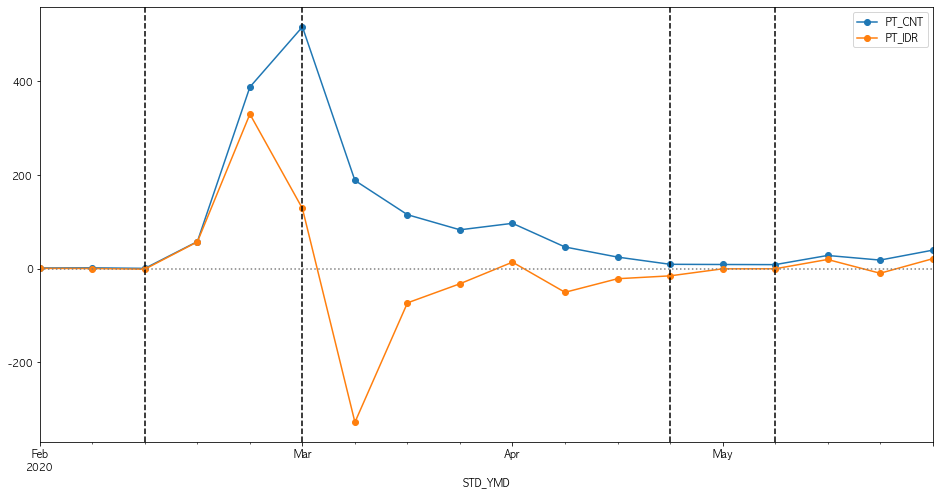

In [12]:
fig, ax = plt.subplots(figsize=(16, 8))
start, end = ax.get_ylim()
nation.plot(marker='o', ax=ax)

plt.axvline(2615, start, end, color='black', linestyle='--')
plt.axvline(2618, start, end, color='black', linestyle='--')
plt.axvline(2625, start, end, color='black', linestyle='--')
plt.axvline(2627, start, end, color='black', linestyle='--')
plt.axhline(0, color='gray', linestyle=':')

plt.show()

In [13]:
initiate = [slice('2019-02-01', '2019-02-21') , slice('2020-02-01', '2020-02-21')]
spread = [slice('2019-02-22', '2019-03-13'), slice('2020-02-22', '2020-03-13')]
recovery = [slice('2019-03-14', '2019-05-01'), slice('2020-03-14', '2020-05-01')]
stability = [slice('2019-05-02', '2019-05-15'), slice('2020-05-02', '2020-05-15')]
re_spread = [slice('2019-05-16', '2019-05-31'), slice('2020-05-16', '2020-05-31')]

In [14]:
periods = [initiate, spread, recovery, stability, re_spread]
naming = ['INIT', 'SPREAD', 'RECOV', 'STABILITY', 'RE_SPREAD']

### 유동인구

In [15]:
for aged in range(20, 70, 10):
    for gender in ['F', 'M']:
        colname = f'AG_{aged}_{gender}'
        table[colname] = table[colname] * table['POP_CNT']

In [16]:
age_cols = re.findall('AG_[0-9]{2}_[MF]', ' '.join(table.columns))

In [17]:
flow = pd.concat([table.iloc[:, :2], table[age_cols], table['POP_CNT']], axis=1) \
         .groupby([pd.Grouper(freq='D'), 'HDONG_NM'])[age_cols + ['POP_CNT']].mean() \
         .reset_index().set_index('STD_YMD')

In [18]:
for i in range(20, 70, 10):
    flow[f'AG_{i}'] = flow[f'AG_{i}_F'] + flow[f'AG_{i}_M']
    
flow = flow[['HDONG_NM'] + [f'AG_{i}' for i in range(20, 70, 10)]]

In [19]:
def flow_features(df):
    result = []
    for idx in range(5):
        last = df[periods[idx][0]].groupby('HDONG_NM')[df.columns[1:]].mean()
        present = df[periods[idx][1]].groupby('HDONG_NM')[df.columns[1:]].mean()
        idr = (present - last) / last
        result.append(idr)
    
    return result

In [20]:
features_list = flow_features(flow)

### 카드매출

In [21]:
elasticity = pd.DataFrame()
cols = ['GU_NM', 'HDONG_NM', 'POP_CNT'] + re.findall('[A-Z_]+_AMT', ' '.join(table.columns))
df = table[cols]
for name, period in zip(naming, periods):
    present = df[period[1]][['POP_CNT'] + re.findall('[A-Z_]+_AMT', ' '.join(table.columns))].sum()
    last = df[period[0]][['POP_CNT'] + re.findall('[A-Z_]+_AMT', ' '.join(table.columns))].sum()
    idr = (present - last) / last
    elasticity[f'{name}'] = (idr[1:] / idr[0]).drop(index='USE_AMT')
elasticity['MEAN'] = elasticity.mean(axis=1)
elasticity.sort_values(by='MEAN', ascending=False)

,INIT,SPREAD,RECOV,STABILITY,RE_SPREAD,MEAN
HOBBY_AMT,2.468214,1.708734,1.471642,1.283790,1.664831,1.719442
CLOTHES_AMT,2.720394,2.098772,1.897738,1.950591,-0.105607,1.712378
LODGE_AMT,0.839011,1.332755,1.636064,1.404339,2.015599,1.445554
ACC_AMT,1.669812,1.593566,1.370806,1.384905,0.779961,1.359810
OPTICAL_AMT,1.415239,1.333079,1.090860,0.533221,1.740636,1.222607
FUEL_AMT,0.878571,0.870114,1.044447,1.717345,1.564145,1.214924
OFFICE_AMT,-0.235024,1.107674,1.302020,1.821050,1.827916,1.164727
APPL_AMT,1.839459,1.220667,1.185234,0.571978,0.245127,1.012493
HYGIENE_AMT,1.239994,1.349943,1.237294,1.358949,-0.525432,0.932149
BOOK_AMT,0.721696,1.671161,0.962010,0.401334,-0.098225,0.731595


* 전체기간 평균 탄력도가 1보다 크면 유동인구에 탄력적 산업군
* 0과 1 사이이면 비탄력적 산업군
* 0과 -1 사이이면 역 비탄력적 산업군

In [22]:
elastic = elasticity[elasticity['MEAN'] > 1].index
elastic = re.sub('_AMT', '', ' '.join(elastic)).split()
inelastic = elasticity[(0 < elasticity['MEAN']) & (elasticity['MEAN'] < 1)].index
inelastic = re.sub('_AMT', '', ' '.join(inelastic)).split()
neg_inelastic = elasticity[elasticity['MEAN'] < 0].index
neg_inelastic = re.sub('_AMT', '', ' '.join(neg_inelastic)).split()

In [23]:
a_group = [f'SH_{up}_{aged}' for up in elastic for aged in range(20, 70, 10)]
b_group = [f'SH_{up}_{aged}' for up in inelastic for aged in range(20, 70, 10)]
c_group = [f'SH_{up}_{aged}' for up in neg_inelastic for aged in range(20, 70, 10)]
group_list = [a_group, b_group, c_group]
initial_list = ['A', 'B', 'C']

In [24]:
for up in renaming:
    for aged in range(20, 70, 10):
        for gender in ['F', 'M']:
            colname = f'SH_{up}_{aged}_{gender}'
            table[colname] = table[colname] * table[f'{up}_AMT']

In [25]:
sh_cols = re.findall('SH_[A-Z_]+_[0-9]{2}_[MF]', ' '.join(table.columns))

In [26]:
amount = pd.concat([table.iloc[:, :2], table[sh_cols]], axis=1)

In [27]:
for up in renaming:
    for i in range(20, 70, 10):
        amount[f'SH_{up}_{i}'] = amount[f'SH_{up}_{i}_F'] + amount[f'SH_{up}_{i}_M']
        
amount = amount[['HDONG_NM'] + [f'SH_{up}_{i}' for up in renaming for i in range(20, 70, 10)]]

In [28]:
def amount_features(df, df2, idx):
    last = df[periods[idx][0]].groupby('HDONG_NM')[df.columns[1:]].mean()
    present = df[periods[idx][1]].groupby('HDONG_NM')[df.columns[1:]].mean()
    for initial, group in zip(initial_list, group_list):
        for aged in range(20, 70, 10):
            a = last[re.findall(f'[A-Z_]+_{aged}', ' '.join(group))].mean(axis=1)
            b = present[re.findall(f'[A-Z_]+_{aged}', ' '.join(group))].mean(axis=1)            
            series = pd.Series(((b - a) / a), name=f'GROUP_{initial}_{aged}')
            df2 = pd.concat([df2, series], axis=1)
            
    return df2

In [29]:
for idx, features in enumerate(features_list):
    features_list[idx] = amount_features(amount, features, idx)

**CJ**

In [30]:
cj_cols = re.findall('CJ_[A-Z]+', ' '.join(table.columns))

In [31]:
deliv = pd.concat([table.iloc[:, :2], table[cj_cols], table['INV_CNT']], axis=1) \
          .groupby([pd.Grouper(freq='D'), 'HDONG_NM'])[cj_cols+['INV_CNT']].mean() \
          .reset_index().set_index('STD_YMD')

In [32]:
deliv.iloc[:, 1:-1] = deliv.iloc[:, 1:-1].apply(lambda x: x*deliv['INV_CNT'])
deliv.drop('INV_CNT', axis=1, inplace=True)

In [33]:
def delivery_features(df, df2, idx):
    last = df[periods[idx][0]].groupby('HDONG_NM')[df.columns[1:]].mean()
    present = df[periods[idx][1]].groupby('HDONG_NM')[df.columns[1:]].mean()
    result = pd.concat([df2, ((present - last) / last)], axis=1)
    return result

In [34]:
for idx, features in enumerate(features_list):
    features_list[idx] = delivery_features(deliv, features, idx)

In [35]:
for idx, features in enumerate(features_list):
    features_list[idx] = features.drop(['대봉2동', '남산3동'])

In [36]:
with open('features_list.bin', 'wb') as f:
    pickle.dump(features_list, f)
    f.close()